# Predicting flood occurrence
Flood occurrences in downtown Norfolk are predicted based on rain, tide levels, water table levels, and wind speed/direction. 

In [1]:
repo = "http://cran.us.r-project.org"
library(caret)
library(ggfortify)
library(rpart)
library(rpart.plot)
library(RSQLite)
library(DBI)
library(randomForest)
library(e1071)
library(class)

Warning message:
"package 'caret' was built under R version 3.3.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggfortify' was built under R version 3.3.3"Warning message:
"package 'rpart.plot' was built under R version 3.3.3"Warning message:
"package 'RSQLite' was built under R version 3.3.3"Warning message:
"package 'DBI' was built under R version 3.3.3"Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Warning message:
"package 'e1071' was built under R version 3.3.3"

In [2]:
classify_knn = function(pca.data, obs_data, point, k){
  neighs = get_nn(pca.data, point, k)
  neigh_data = obs_data[neighs,]
  return(names(which.max(table(neigh_data$fld))))
}

In [3]:
get_nn = function(d, point, k){
  point = d[point, ]
  dists = sort(sqrt(rowSums((t(t(d) - point))^2)))
  close_points = names(dists)[2:k]
  return(close_points)
}

In [4]:
base_dir<- "C:/Users/Jeff/Documents/research/Sadler_3rdPaper/manuscript/"
data_dir<- paste(base_dir, "Data/", sep="")
fig_dir <- paste(base_dir, "Figures/general/", sep="")
db_filename <- "floodData.sqlite"

In [5]:
con = dbConnect(RSQLite::SQLite(), dbname=paste(data_dir, db_filename, sep=""))

In [6]:
df = dbReadTable(con, 'for_model')
df = subset(df, rain_daily_sum>0.1) # only look at days that have over 0.1 in of rainfall
df = df[!is.na(df$gw_daily_avg),] # remove null gw values
short_names = c('rd', 'rhr', 'rhmxtime', 'r15', 'r15mxtime', 'r3d', 'gw', 'td', 'tr15mx', 'trhrmx', 'wdd', 'wvd',  'wvh', 'nfld', 'fld', 'evnme', 'evdte')
colnames(df) = short_names

In [7]:
in_col_names = c('rd', 'rhr', 'r15', 'r3d', 'gw', 'td', 'wvd', 'tr15mx', 'trhrmx')
out_col_name = 'fld'
model_data = df[, c(in_col_names, out_col_name)]
model_data$fld = df$fld>0
model_data$fld = factor(model_data$fld)

### Partition data into training and testing sets

In [8]:
prt = createDataPartition(model_data$fld, p=0.7)
train_ind = prt$Resample1

### Scale data

In [9]:
train_in_data = model_data[train_ind, in_col_names]
test_in_data = model_data[-train_ind, in_col_names]

In [10]:
train_col_stds = apply(train_in_data, 2, sd)
train_col_means = colMeans(train_in_data)

In [11]:
train_normalized = t((t(train_in_data)-train_col_means)/train_col_stds)
test_normalized = t((t(test_in_data)-train_col_means)/train_col_stds)

### PCA transform

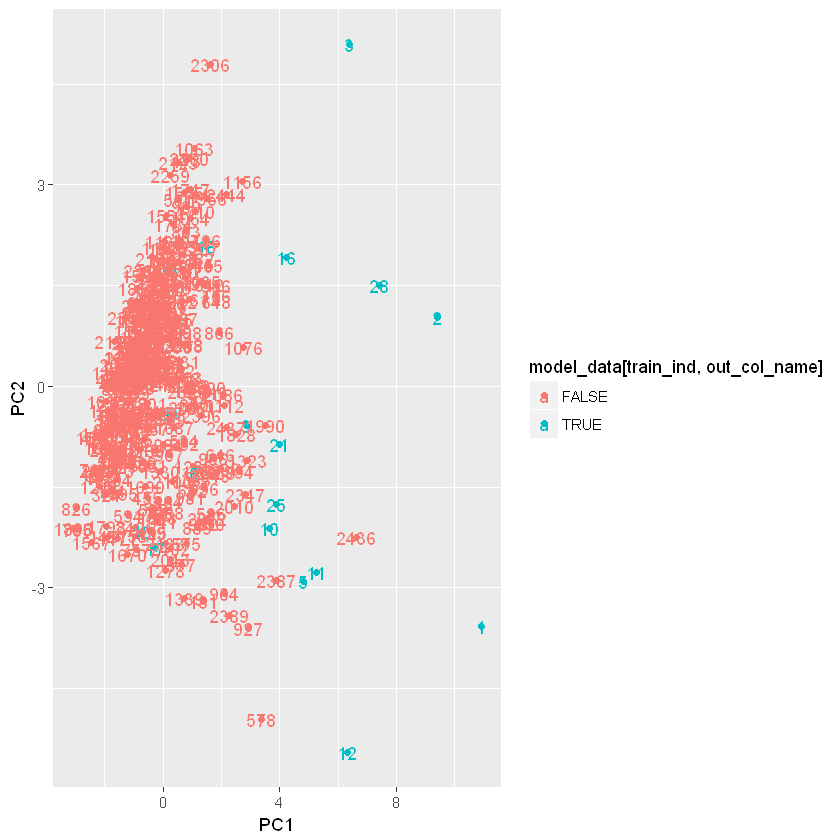

Standard deviations:
[1] 1.7253444 1.5213993 1.1115690 0.9588596 0.7865388 0.7055031 0.5416526
[8] 0.2796499 0.2560549

Rotation:
              PC1        PC2         PC3         PC4         PC5          PC6
rd      0.4575263 -0.1363428  0.32442757  0.06317982  0.15939945 -0.124041209
rhr     0.4164493 -0.3755602 -0.19779769 -0.16032858 -0.27635162 -0.008344257
r15     0.3741623 -0.3767009 -0.28801319 -0.17320606 -0.36029218  0.079709909
r3d     0.4029044 -0.1781672  0.26760514  0.06219849  0.63530032 -0.167742666
gw     -0.0235433  0.1627390  0.37833539 -0.90771779 -0.01793588  0.065786330
td      0.3435118  0.3344620  0.03456892  0.12711601  0.05018923  0.863861496
wvd     0.1729583  0.2172901  0.61085230  0.29418326 -0.60122756 -0.196466058
tr15mx  0.2912812  0.4809423 -0.31407814 -0.08877019  0.02186938 -0.305312099
trhrmx  0.2856506  0.4998487 -0.29144540 -0.04358978  0.00333886 -0.260103760
               PC7          PC8          PC9
rd      0.77240642 -0.050939035  0.151110903


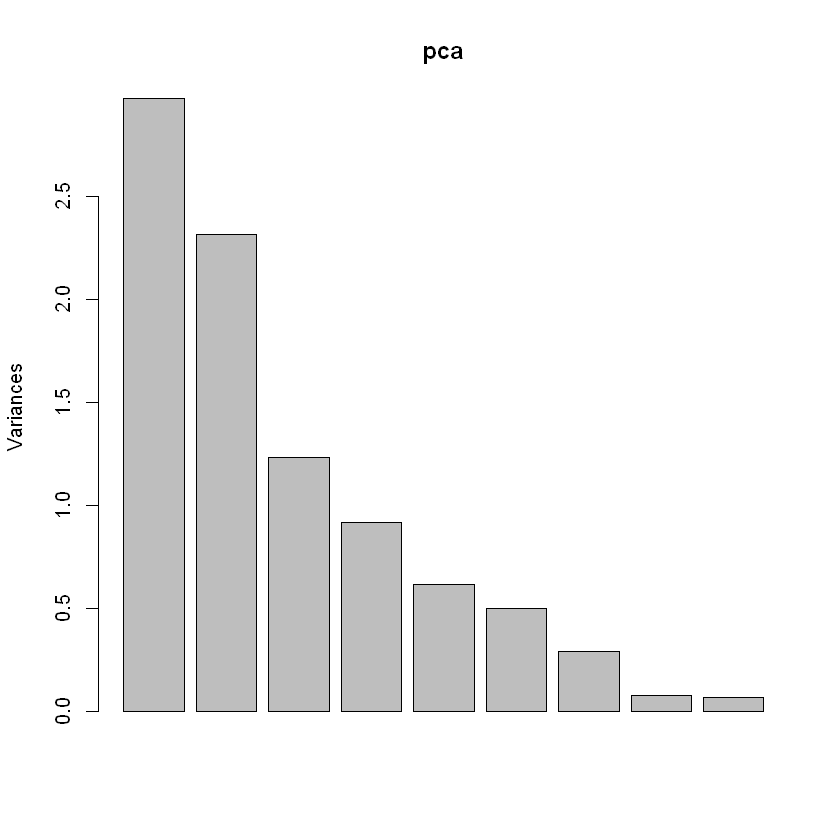

In [12]:
pca = prcomp(train_normalized)
pca$x = -pca$x
pca$rotation=-pca$rotation
p = ggplot(pca$x[,c(1,2)], aes(x=PC1, y=PC2, colour=model_data[train_ind, out_col_name], label=rownames(pca$x)))
p + geom_point() + geom_text()
plot(pca)
print(pca)

In [13]:
trn_preprocessed = predict(pca, train_normalized)
tst_preprocessed = predict(pca, test_normalized)
trn_in = trn_preprocessed
tst_in = tst_preprocessed

In [14]:
tst_out = model_data[-train_ind, 'fld']
trn_out = model_data[train_ind, 'fld']
train_data = cbind(as.data.frame(trn_in), fld = model_data[train_ind, 'fld'])
fmla = as.formula(paste(out_col_name, "~", paste(colnames(trn_in), collapse="+")))
fmla

fld ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9

### KNN

In [15]:
kfit = knn(trn_in, tst_in, trn_out, k=5)
table(tst_out, kfit)

       kfit
tst_out FALSE TRUE
  FALSE   140    2
  TRUE      6    1

### SVM

In [16]:
svm_fit = svm(fmla, data=train_data)
svm_pred = predict(svm_fit, tst_in)
table(tst_out, svm_pred)

       svm_pred
tst_out FALSE TRUE
  FALSE   142    0
  TRUE      7    0

### Decision Trees

In [17]:
dt_fmla = as.formula(paste(out_col_name, "~", paste(in_col_names, collapse="+")))
dt_train_data = model_data[train_ind, ]
dt_test_data = model_data[-train_ind, in_col_names]

In [18]:
fit = rpart(dt_fmla, method='class', data=dt_train_data, minsplit=2)
printcp(fit)


Classification tree:
rpart(formula = dt_fmla, data = dt_train_data, method = "class", 
    minsplit = 2)

Variables actually used in tree construction:
[1] gw     r15    r3d    rd     rhr    tr15mx trhrmx

Root node error: 18/352 = 0.051136

n= 352 

        CP nsplit rel error  xerror    xstd
1 0.333333      0  1.000000 1.00000 0.22960
2 0.166667      1  0.666667 1.05556 0.23553
3 0.055556      2  0.500000 0.77778 0.20369
4 0.037037      6  0.277778 1.05556 0.23553
5 0.027778      9  0.166667 1.11111 0.24129
6 0.018519     11  0.111111 1.16667 0.24688
7 0.010000     14  0.055556 1.22222 0.25230


png 
  2

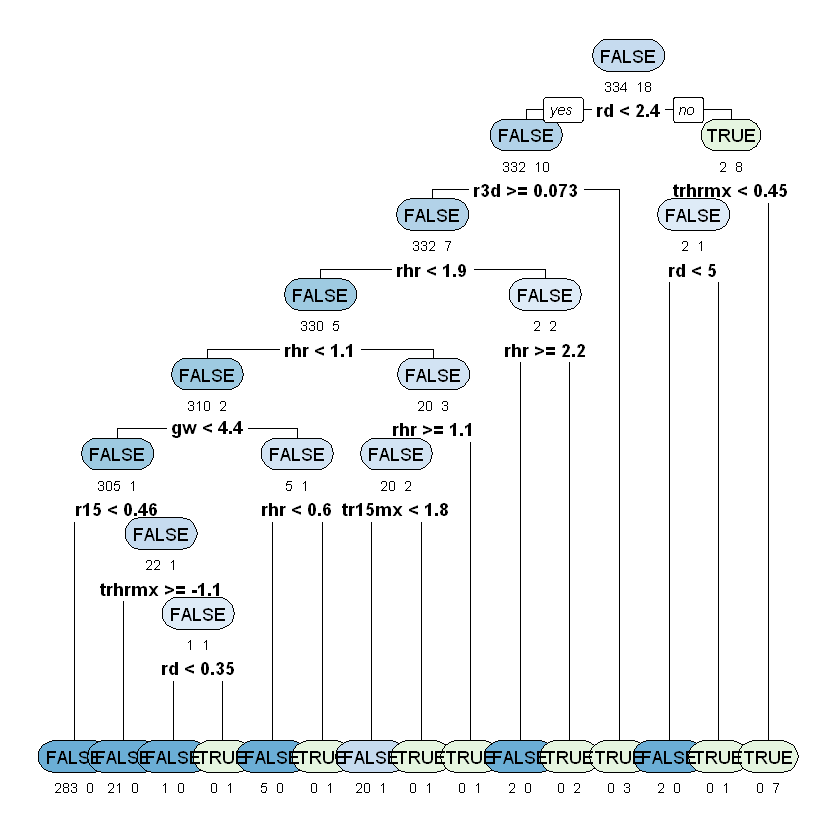

In [19]:
tiff(paste(fig_dir, "Plot2.tif"), width=9, height=6, units='in', res = 300)
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)
dev.off()
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)

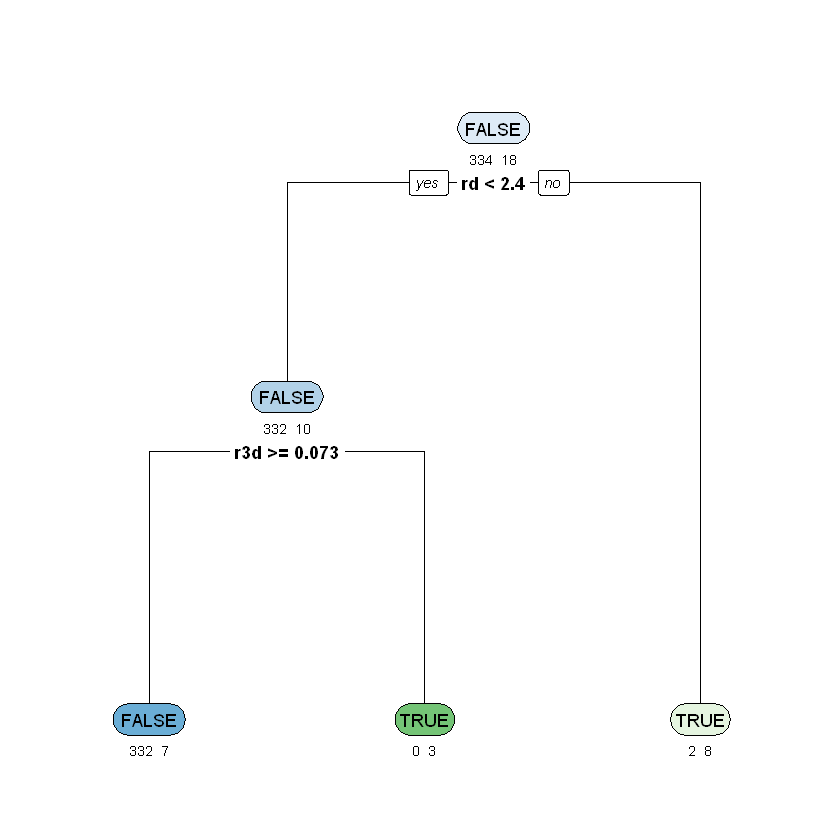

In [20]:
pfit<- prune(fit, cp=fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
rpart.plot(pfit, under=TRUE, cex=0.9, extra=1, varlen = 6)

#### Decision Tree training results

In [21]:
pred = predict(pfit, dt_train_data[, in_col_names], type = 'class')
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   332    2
  TRUE      7   11

#### Decision Tree testing results

In [22]:
pred = predict(pfit, dt_test_data, type = 'class')
table(tst_out, pred)

       pred
tst_out FALSE TRUE
  FALSE   141    1
  TRUE      3    4

### Random Forests

In [23]:
forest = randomForest(fmla, data = train_data, importance = TRUE, type="classification", nodesize=2)

pred = predict(forest, trn_in)
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   334    0
  TRUE      0   18

In [24]:
pred = predict(forest, tst_in)
table(tst_out, pred)
forest$importance

       pred
tst_out FALSE TRUE
  FALSE   139    3
  TRUE      5    2

,FALSE,TRUE,MeanDecreaseAccuracy,MeanDecreaseGini
PC1,0.0192471540,0.2220709235,0.0296380596,11.047471
PC2,0.0005615138,-0.0150645022,-0.0001876255,2.222659
PC3,0.0003604967,-0.0003118326,0.0003939761,2.500869
PC4,0.0013261706,0.0090215729,0.0016965790,2.998466
PC5,0.0067250209,0.0079572872,0.0067918407,3.588847
PC6,0.0009843255,0.0062602453,0.0012628235,3.386835
PC7,0.0060552528,0.0212531746,0.0068183352,2.939536
PC8,0.0001669275,0.0114310967,0.0007223209,1.392661
PC9,0.0005137704,0.0145390332,0.0013187514,2.612724


### Logistic Regression

In [25]:
lo_fit = glm(fmla, family=binomial(link='logit'), data=train_data)
print(lo_fit)


Call:  glm(formula = fmla, family = binomial(link = "logit"), data = train_data)

Coefficients:
(Intercept)          PC1          PC2          PC3          PC4          PC5  
   -4.65015      1.03238     -0.05154      0.35704     -0.68986     -0.98617  
        PC6          PC7          PC8          PC9  
    0.61232      2.49999      1.51311     -1.04854  

Degrees of Freedom: 351 Total (i.e. Null);  342 Residual
Null Deviance:	    142.1 
Residual Deviance: 57.15 	AIC: 77.15


In [26]:
pred = predict(lo_fit, as.data.frame(tst_in), type="response")
table(tst_out, round(pred)>0)

       
tst_out FALSE TRUE
  FALSE   140    2
  TRUE      3    4